In [1]:
import numpy as np
from parse_lsp_data import *
import tensorflow as tf

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras.preprocessing import image
from keras import applications
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model,Input
from keras.utils import np_utils
from keras.models import Sequential
from keras.callbacks import CSVLogger
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout,Reshape
from keras.optimizers import SGD,Adam
import keras.backend as K
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Flatten,Activation, Average,GlobalAveragePooling2D

Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6388665132928973839
]


In [111]:
# get the data set
train_list, train_label, val_list, val_label, test_list, test_label = getLSPDataset(0.8, 0.1)

Resizing and packing images and labels to lists.

Start to process training dataset
Done processing the training dataset
Start to process validation dataset
Done processing the validation dataset
Start to process test dataset
Done processing the test dataset


In [112]:
# print some information
train_X = train_list	# (N, 227, 227, 3)
train_Y = train_label	# (N, 2, 14)
print("train X: ", train_list.shape, "val X: ", val_list.shape, "test X: ", test_list.shape)
print("train Y: ", train_label.shape, "val Y: ", val_label.shape, "test Y: ", test_label.shape)

train X:  (1600, 227, 227, 3) val X:  (200, 227, 227, 3) test X:  (200, 227, 227, 3)
train Y:  (1600, 2, 14) val Y:  (200, 2, 14) test Y:  (200, 2, 14)


In [8]:
# model_input = Input(shape=(227,227,3))

In [6]:
# build keras model
def build_model():
    base_model = applications.resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(227,227, 3))
    last = base_model.output
    x = Flatten()(last)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.7)(x)
    x = Dense(28, activation='relu')(x)
    preds = Reshape((2,14))(x)
    model = Model(base_model.input, preds)
    return model

In [10]:
model = build_model()

In [11]:
#model.summary()

In [9]:
# custom loss function (L2 distance)
def euclidean_distance_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))

In [10]:
def loss_accuracy(y_true, y_pred):
    diff = tf.square(y_true - y_pred)
    loss = tf.reduce_sum(diff)
    dist = tf.sqrt(tf.reduce_sum(diff, axis = 1))	# (N, 2, 14) -> (N, 14)
    accuracy = tf.reduce_sum(tf.to_int32(tf.greater(1.0, dist))) / 64/14
    return accuracy

In [14]:
# compile the model
model.compile(optimizer=Adam(), loss=euclidean_distance_loss, metrics=[loss_accuracy])

In [15]:
csv_logger = CSVLogger('resnet50_v2.csv', append=True, separator=';')

In [16]:
with tf.device('/device:GPU:0'):
    # fit the model
    history = model.fit(train_X, train_Y, epochs=1000,batch_size=64, validation_data = (val_list,val_label),callbacks=[csv_logger])

Train on 1600 samples, validate on 200 samples
Epoch 1/1000
1600/1600 [==============================] - 37s 23ms/step - loss: 175.6263 - loss_accuracy: 4.4643e-04 - val_loss: 209.8679 - val_loss_accuracy: 0.0000e+00
Epoch 2/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 124.7356 - loss_accuracy: 7.1429e-04 - val_loss: 180.2802 - val_loss_accuracy: 0.0000e+00
Epoch 3/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 120.4799 - loss_accuracy: 7.1429e-04 - val_loss: 148.7579 - val_loss_accuracy: 7.1429e-04
Epoch 4/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 117.8962 - loss_accuracy: 7.5893e-04 - val_loss: 151.5309 - val_loss_accuracy: 3.5714e-04
Epoch 5/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 115.1224 - loss_accuracy: 8.0357e-04 - val_loss: 109.0419 - val_loss_accuracy: 0.0000e+00
Epoch 6/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 113.4866 - loss_accuracy: 8.

1600/1600 [==============================] - 13s 8ms/step - loss: 54.5110 - loss_accuracy: 0.0033 - val_loss: 70.3136 - val_loss_accuracy: 0.0033
Epoch 103/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 55.1993 - loss_accuracy: 0.0036 - val_loss: 75.4104 - val_loss_accuracy: 0.0036
Epoch 104/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 54.2283 - loss_accuracy: 0.0039 - val_loss: 76.7346 - val_loss_accuracy: 3.5714e-04
Epoch 105/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 54.3063 - loss_accuracy: 0.0034 - val_loss: 71.0016 - val_loss_accuracy: 0.0032
Epoch 106/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 54.4300 - loss_accuracy: 0.0029 - val_loss: 70.8889 - val_loss_accuracy: 0.0029
Epoch 107/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 54.2454 - loss_accuracy: 0.0037 - val_loss: 71.1197 - val_loss_accuracy: 0.0065
Epoch 108/1000
1600/1600 [===================

Epoch 153/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 50.8848 - loss_accuracy: 0.0038 - val_loss: 68.4048 - val_loss_accuracy: 0.0075
Epoch 154/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 49.8956 - loss_accuracy: 0.0048 - val_loss: 75.2595 - val_loss_accuracy: 0.0018
Epoch 155/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 50.2344 - loss_accuracy: 0.0041 - val_loss: 78.1634 - val_loss_accuracy: 0.0014
Epoch 156/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 50.2469 - loss_accuracy: 0.0042 - val_loss: 83.8728 - val_loss_accuracy: 7.1429e-04
Epoch 157/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 50.6892 - loss_accuracy: 0.0037 - val_loss: 70.5586 - val_loss_accuracy: 0.0061
Epoch 158/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 51.1615 - loss_accuracy: 0.0035 - val_loss: 77.1986 - val_loss_accuracy: 0.0039
Epoch 159/1000
1600/1600 [====

Epoch 204/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 47.2057 - loss_accuracy: 0.0036 - val_loss: 65.9368 - val_loss_accuracy: 0.0072
Epoch 205/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 47.5057 - loss_accuracy: 0.0046 - val_loss: 67.2022 - val_loss_accuracy: 0.0083
Epoch 206/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 47.2864 - loss_accuracy: 0.0049 - val_loss: 68.4541 - val_loss_accuracy: 0.0050
Epoch 207/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 47.3684 - loss_accuracy: 0.0055 - val_loss: 69.8396 - val_loss_accuracy: 0.0057
Epoch 208/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 46.7027 - loss_accuracy: 0.0042 - val_loss: 74.4631 - val_loss_accuracy: 0.0018
Epoch 209/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 47.4852 - loss_accuracy: 0.0047 - val_loss: 69.8285 - val_loss_accuracy: 0.0019
Epoch 210/1000
1600/1600 [========

Epoch 255/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 44.5928 - loss_accuracy: 0.0050 - val_loss: 66.6318 - val_loss_accuracy: 0.0089
Epoch 256/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 44.0952 - loss_accuracy: 0.0050 - val_loss: 64.7603 - val_loss_accuracy: 0.0072
Epoch 257/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 44.4090 - loss_accuracy: 0.0048 - val_loss: 68.0644 - val_loss_accuracy: 0.0036
Epoch 258/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 44.7241 - loss_accuracy: 0.0051 - val_loss: 68.3027 - val_loss_accuracy: 0.0044
Epoch 259/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 44.3631 - loss_accuracy: 0.0053 - val_loss: 67.2136 - val_loss_accuracy: 0.0083
Epoch 260/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 44.4593 - loss_accuracy: 0.0054 - val_loss: 66.2368 - val_loss_accuracy: 0.0073
Epoch 261/1000
1600/1600 [========

Epoch 306/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 41.1468 - loss_accuracy: 0.0056 - val_loss: 64.9106 - val_loss_accuracy: 0.0071
Epoch 307/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 41.9148 - loss_accuracy: 0.0061 - val_loss: 68.0382 - val_loss_accuracy: 0.0058
Epoch 308/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 40.6584 - loss_accuracy: 0.0066 - val_loss: 75.1396 - val_loss_accuracy: 0.0075
Epoch 309/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 41.3526 - loss_accuracy: 0.0058 - val_loss: 63.9714 - val_loss_accuracy: 0.0093
Epoch 310/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 41.3279 - loss_accuracy: 0.0058 - val_loss: 68.0268 - val_loss_accuracy: 0.0061
Epoch 311/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 41.1624 - loss_accuracy: 0.0065 - val_loss: 68.2108 - val_loss_accuracy: 0.0040
Epoch 312/1000
1600/1600 [========

Epoch 357/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 38.5381 - loss_accuracy: 0.0067 - val_loss: 63.8290 - val_loss_accuracy: 0.0061
Epoch 358/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 38.2247 - loss_accuracy: 0.0071 - val_loss: 67.8273 - val_loss_accuracy: 0.0068
Epoch 359/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 38.1347 - loss_accuracy: 0.0072 - val_loss: 66.4720 - val_loss_accuracy: 0.0050
Epoch 360/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 38.5877 - loss_accuracy: 0.0062 - val_loss: 65.6483 - val_loss_accuracy: 0.0068
Epoch 361/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 38.2404 - loss_accuracy: 0.0065 - val_loss: 64.5930 - val_loss_accuracy: 0.0075
Epoch 362/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 38.1421 - loss_accuracy: 0.0077 - val_loss: 65.4322 - val_loss_accuracy: 0.0064
Epoch 363/1000
1600/1600 [========

Epoch 408/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 37.0147 - loss_accuracy: 0.0069 - val_loss: 64.3717 - val_loss_accuracy: 0.0087
Epoch 409/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 37.1029 - loss_accuracy: 0.0074 - val_loss: 63.7835 - val_loss_accuracy: 0.0086
Epoch 410/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 36.8997 - loss_accuracy: 0.0064 - val_loss: 65.1484 - val_loss_accuracy: 0.0068
Epoch 411/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 37.1957 - loss_accuracy: 0.0074 - val_loss: 63.9752 - val_loss_accuracy: 0.0068
Epoch 412/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 36.9582 - loss_accuracy: 0.0053 - val_loss: 65.2086 - val_loss_accuracy: 0.0083
Epoch 413/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 37.2537 - loss_accuracy: 0.0070 - val_loss: 62.5101 - val_loss_accuracy: 0.0061
Epoch 414/1000
1600/1600 [========

Epoch 459/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 35.9098 - loss_accuracy: 0.0077 - val_loss: 62.9359 - val_loss_accuracy: 0.0100
Epoch 460/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 36.1026 - loss_accuracy: 0.0071 - val_loss: 63.4159 - val_loss_accuracy: 0.0075
Epoch 461/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 35.8767 - loss_accuracy: 0.0078 - val_loss: 65.2638 - val_loss_accuracy: 0.0097
Epoch 462/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 35.9972 - loss_accuracy: 0.0069 - val_loss: 66.0364 - val_loss_accuracy: 0.0075
Epoch 463/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 35.8824 - loss_accuracy: 0.0071 - val_loss: 66.2737 - val_loss_accuracy: 0.0072
Epoch 464/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 35.7694 - loss_accuracy: 0.0081 - val_loss: 64.8430 - val_loss_accuracy: 0.0104
Epoch 465/1000
1600/1600 [========

Epoch 510/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 35.4497 - loss_accuracy: 0.0077 - val_loss: 64.7022 - val_loss_accuracy: 0.0079
Epoch 511/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 35.0364 - loss_accuracy: 0.0068 - val_loss: 64.6976 - val_loss_accuracy: 0.0079
Epoch 512/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 35.5594 - loss_accuracy: 0.0065 - val_loss: 63.6038 - val_loss_accuracy: 0.0097
Epoch 513/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 35.2406 - loss_accuracy: 0.0079 - val_loss: 63.5604 - val_loss_accuracy: 0.0075
Epoch 514/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 35.2349 - loss_accuracy: 0.0069 - val_loss: 62.5645 - val_loss_accuracy: 0.0104
Epoch 515/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 35.4033 - loss_accuracy: 0.0089 - val_loss: 62.8694 - val_loss_accuracy: 0.0093
Epoch 516/1000
1600/1600 [========

Epoch 561/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 35.0040 - loss_accuracy: 0.0080 - val_loss: 63.8749 - val_loss_accuracy: 0.0066
Epoch 562/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 34.6317 - loss_accuracy: 0.0083 - val_loss: 63.2331 - val_loss_accuracy: 0.0064
Epoch 563/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 35.1016 - loss_accuracy: 0.0071 - val_loss: 64.0315 - val_loss_accuracy: 0.0094
Epoch 564/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 34.4958 - loss_accuracy: 0.0081 - val_loss: 62.5047 - val_loss_accuracy: 0.0100
Epoch 565/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 34.5383 - loss_accuracy: 0.0083 - val_loss: 62.3791 - val_loss_accuracy: 0.0089
Epoch 566/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 34.4291 - loss_accuracy: 0.0090 - val_loss: 63.0208 - val_loss_accuracy: 0.0075
Epoch 567/1000
1600/1600 [========

Epoch 612/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.9419 - loss_accuracy: 0.0078 - val_loss: 63.3408 - val_loss_accuracy: 0.0104
Epoch 613/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 34.3397 - loss_accuracy: 0.0076 - val_loss: 64.7764 - val_loss_accuracy: 0.0071
Epoch 614/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 34.1298 - loss_accuracy: 0.0086 - val_loss: 64.0126 - val_loss_accuracy: 0.0107
Epoch 615/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 34.4137 - loss_accuracy: 0.0074 - val_loss: 61.5074 - val_loss_accuracy: 0.0096
Epoch 616/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 34.3369 - loss_accuracy: 0.0077 - val_loss: 63.3649 - val_loss_accuracy: 0.0104
Epoch 617/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.8176 - loss_accuracy: 0.0073 - val_loss: 64.8051 - val_loss_accuracy: 0.0097
Epoch 618/1000
1600/1600 [========

Epoch 663/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.8674 - loss_accuracy: 0.0087 - val_loss: 64.2174 - val_loss_accuracy: 0.0057
Epoch 664/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.9929 - loss_accuracy: 0.0083 - val_loss: 65.1076 - val_loss_accuracy: 0.0097
Epoch 665/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.4778 - loss_accuracy: 0.0086 - val_loss: 67.8581 - val_loss_accuracy: 0.0082
Epoch 666/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 34.5644 - loss_accuracy: 0.0068 - val_loss: 76.6141 - val_loss_accuracy: 0.0043
Epoch 667/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.6918 - loss_accuracy: 0.0085 - val_loss: 69.7597 - val_loss_accuracy: 0.0093
Epoch 668/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.7042 - loss_accuracy: 0.0083 - val_loss: 70.5360 - val_loss_accuracy: 0.0061
Epoch 669/1000
1600/1600 [========

Epoch 714/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.0541 - loss_accuracy: 0.0080 - val_loss: 63.6482 - val_loss_accuracy: 0.0068
Epoch 715/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.3798 - loss_accuracy: 0.0088 - val_loss: 64.5083 - val_loss_accuracy: 0.0086
Epoch 716/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.0519 - loss_accuracy: 0.0081 - val_loss: 62.4795 - val_loss_accuracy: 0.0115
Epoch 717/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.4941 - loss_accuracy: 0.0063 - val_loss: 63.8978 - val_loss_accuracy: 0.0062
Epoch 718/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.0967 - loss_accuracy: 0.0078 - val_loss: 65.5221 - val_loss_accuracy: 0.0080
Epoch 719/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.0900 - loss_accuracy: 0.0075 - val_loss: 64.9053 - val_loss_accuracy: 0.0114
Epoch 720/1000
1600/1600 [========

Epoch 765/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.1395 - loss_accuracy: 0.0096 - val_loss: 64.8862 - val_loss_accuracy: 0.0104
Epoch 766/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.8668 - loss_accuracy: 0.0086 - val_loss: 65.2577 - val_loss_accuracy: 0.0082
Epoch 767/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.9929 - loss_accuracy: 0.0074 - val_loss: 65.1728 - val_loss_accuracy: 0.0068
Epoch 768/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.7922 - loss_accuracy: 0.0083 - val_loss: 64.3218 - val_loss_accuracy: 0.0104
Epoch 769/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.9036 - loss_accuracy: 0.0084 - val_loss: 65.7493 - val_loss_accuracy: 0.0061
Epoch 770/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.8060 - loss_accuracy: 0.0090 - val_loss: 66.1987 - val_loss_accuracy: 0.0118
Epoch 771/1000
1600/1600 [========

Epoch 816/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.7656 - loss_accuracy: 0.0083 - val_loss: 65.1285 - val_loss_accuracy: 0.0086
Epoch 817/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.5869 - loss_accuracy: 0.0083 - val_loss: 63.7027 - val_loss_accuracy: 0.0075
Epoch 818/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.8777 - loss_accuracy: 0.0092 - val_loss: 64.6769 - val_loss_accuracy: 0.0086
Epoch 819/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.7238 - loss_accuracy: 0.0096 - val_loss: 63.9738 - val_loss_accuracy: 0.0083
Epoch 820/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.6438 - loss_accuracy: 0.0086 - val_loss: 64.6417 - val_loss_accuracy: 0.0111
Epoch 821/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 33.0234 - loss_accuracy: 0.0073 - val_loss: 62.8336 - val_loss_accuracy: 0.0125
Epoch 822/1000
1600/1600 [========

Epoch 867/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.3328 - loss_accuracy: 0.0087 - val_loss: 66.2154 - val_loss_accuracy: 0.0072
Epoch 868/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.6398 - loss_accuracy: 0.0078 - val_loss: 65.1131 - val_loss_accuracy: 0.0100
Epoch 869/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.6210 - loss_accuracy: 0.0079 - val_loss: 63.5615 - val_loss_accuracy: 0.0093
Epoch 870/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.5941 - loss_accuracy: 0.0084 - val_loss: 63.3426 - val_loss_accuracy: 0.0076
Epoch 871/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.4234 - loss_accuracy: 0.0086 - val_loss: 61.6334 - val_loss_accuracy: 0.0068
Epoch 872/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 31.7785 - loss_accuracy: 0.0091 - val_loss: 62.1961 - val_loss_accuracy: 0.0090
Epoch 873/1000
1600/1600 [========

Epoch 918/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.2030 - loss_accuracy: 0.0093 - val_loss: 64.7297 - val_loss_accuracy: 0.0122
Epoch 919/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.1019 - loss_accuracy: 0.0087 - val_loss: 63.5787 - val_loss_accuracy: 0.0097
Epoch 920/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.4823 - loss_accuracy: 0.0089 - val_loss: 65.5083 - val_loss_accuracy: 0.0087
Epoch 921/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.4675 - loss_accuracy: 0.0085 - val_loss: 63.8927 - val_loss_accuracy: 0.0097
Epoch 922/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 31.7721 - loss_accuracy: 0.0089 - val_loss: 64.1210 - val_loss_accuracy: 0.0097
Epoch 923/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 31.9813 - loss_accuracy: 0.0092 - val_loss: 63.4160 - val_loss_accuracy: 0.0083
Epoch 924/1000
1600/1600 [========

Epoch 969/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 31.7303 - loss_accuracy: 0.0089 - val_loss: 62.2621 - val_loss_accuracy: 0.0136
Epoch 970/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 32.2234 - loss_accuracy: 0.0092 - val_loss: 63.7257 - val_loss_accuracy: 0.0097
Epoch 971/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 31.7566 - loss_accuracy: 0.0089 - val_loss: 63.4916 - val_loss_accuracy: 0.0101
Epoch 972/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 31.7275 - loss_accuracy: 0.0084 - val_loss: 62.8513 - val_loss_accuracy: 0.0116
Epoch 973/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 31.9907 - loss_accuracy: 0.0088 - val_loss: 63.0916 - val_loss_accuracy: 0.0072
Epoch 974/1000
1600/1600 [==============================] - 13s 8ms/step - loss: 31.9703 - loss_accuracy: 0.0091 - val_loss: 63.5584 - val_loss_accuracy: 0.0050
Epoch 975/1000
1600/1600 [========

In [17]:
# evaluation
with tf.device('/device:GPU:0'):
    loss,evaluation_metric_loss = model.evaluate(test_list, test_label)

200/200 [==============================] - 1s 4ms/step


In [18]:
print(loss)

64.60715057373046


In [19]:
with tf.device('/device:GPU:0'):
    pred = model.predict(test_list)

In [20]:
print(pred[0])
print(train_Y[0])

[[103.91778  132.92491   77.92124   59.469738  88.20466   55.388943
  168.7496   138.48766  129.57138  116.34833  140.0513   164.0567
  132.86475  144.9862  ]
 [202.12686  154.67287  111.76403  111.34259  146.54451  186.74582
   71.08847   81.03621   57.959663  56.96177   79.76588   71.44909
   48.347523  25.434998]]
[[ 50.20740877  83.82652876  85.02721161 130.65316017 172.67706016
  105.43882018 130.65316017  61.01355448  95.83335733 170.27569445
  142.65998874 173.87774302 141.45930588 151.06476874]
 [206.30842279 161.39537968 115.06402995 115.53679882 160.92261081
  191.65258767  83.38851533  84.80682196  53.60407622  53.60407622
   74.87867558  87.64343521  47.45808084  19.56471723]]


In [ ]:
dist = K.sqrt(K.sum(K.square(pred[0] - test_label[0]), axis=0))

In [ ]:
threshold = np.array(1.0)

In [ ]:
temp = tf.reduce_sum(tf.to_int32(tf.greater(threshold, dist)))

In [ ]:
print(temp.shape)

In [21]:
model.save('resnet50_v2.h5')

In [118]:
# load model
def load_trained_model(weights_path):
    model = build_model()
    model.load_weights(weights_path)
    return model

In [119]:
train_model = load_trained_model('resnet50_v1.h5')

In [120]:
train_model.compile(optimizer=Adam(), loss=euclidean_distance_loss, metrics=[loss_accuracy])

In [121]:
pred = train_model.predict(test_list)

In [122]:
print(pred[0])
print(test_label[0])

[[ 92.05756  124.63836   66.34902   49.82492   88.717026  51.65664
  153.42722  126.86551  117.74381  113.66406  143.12572  167.42068
  126.399315 138.6544  ]
 [190.86751  146.25638  111.190285 108.55626  139.12524  175.36938
   60.428474  70.980835  50.07715   56.995953  79.39584   67.11656
   47.647133  24.547165]]
[[107.15102164 122.65678333  49.77970339  71.48776976  99.3981408
   52.88085573 150.56715438 108.70159781 110.25217398 135.06139269
  167.62349224 173.82579691 127.30851184 141.26369736]
 [199.97733344 151.81434483 110.75737093 111.54692812 143.91877293
  173.13238897  53.11969603  68.12128265  54.69881041  61.80482513
   78.38552613  61.80482513  45.22412413  25.48519437]]


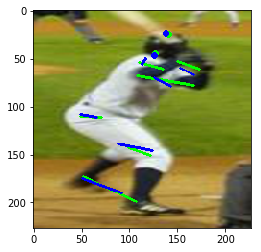

In [124]:
# usage:
drawLines(test_list[0].copy(),test_label[0].copy(),pred[0].copy())